## Data Science Candidate Evaluation: Exploratory Data Analysis for Forecasting Task
### 📄 Introduction
Welcome to the evaluation phase of your application for the Data Science position. This notebook is designed to assess your skills in exploratory data analysis (EDA) and forecasting. You will be provided with a dataset and a series of tasks aimed at testing your ability to interpret data and extract meaningful insights that could inform future forecasting models.

### 🎯 Objective
Your main objective in this notebook is to conduct a thorough exploratory analysis of the provided dataset. You should aim to understand the underlying patterns, trends, and anomalies within the data. The insights you generate here will be pivotal for building robust forecasting models in later stages.

### 📚 Dataset Description
* 	📆 Calendar.csv
    - DATE
    - STORE_ID
    - STATE
        - C : Closed
        - A : Open
        - FA : Open on holiday
        - FM : Open on holiday until noon
        - CR : Closed for renovation
    - OPENING_TIME
    - CLOSING_TIME 
    - HOLIDAY_AND_CLOSED
        - 1: True,  0: False
    - UNDER_REFORM
        - 1: True, 0: False
* 📉 ipc_history.csv
    - Evolution of IPC over time
* 📝 sales_test_submission.csv
    - File for results. Colums SALES must be filled with predictions
* 📈 sales_train_dataset.csv
    - Cumulative sales over time



##### Task 1: Import all necessary libraries

In [93]:
import pandas as pd
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

##### Task 2: Load all CSV files (format data if necessary)

In [94]:
calendar = pd.read_csv('../data/calendar.csv', sep='|')
ipc_history = pd.read_csv('../data/ipc_history.csv', sep='|')
sales_train = pd.read_csv('../data/sales_train_dataset.csv', sep='|')
sales_test = pd.read_csv('../data/sales_test_submission.csv', sep='|')

##### Task 3: Basic sales exploration
* Plot the sales over the year
* Bar graph with sales grouped by month
* Which day of the week (on average) does Mercadona have the best sales?

In [95]:
# Make all the exploration over a copy
sales_exploration = sales_train.copy()
calendar_exploration = calendar.copy()
ipc_history_exploration = ipc_history.copy()

In [96]:
# Basic transformations
# Ensure DATE is type Datetime and SALES is Float
sales_exploration['DATE'] = pd.to_datetime(sales_exploration['DATE'])
sales_exploration['SALES'] = pd.to_numeric(sales_exploration['SALES'], errors='coerce') # There is a line with an 'a' as a SALE instead of a num

# Extract year, month, weekday and dayofyear from DATE
sales_exploration['YEAR'] = sales_exploration['DATE'].dt.year
sales_exploration['MONTH'] = sales_exploration['DATE'].dt.month
# Weekday (0 = Monday, 6 = Sunday)
sales_exploration['WEEKDAY'] = sales_exploration['DATE'].dt.dayofweek
sales_exploration['DAY_OF_YEAR'] = sales_exploration['DATE'].dt.dayofyear
sales_exploration['DAY_OF_MONTH'] = sales_exploration['DATE'].dt.day

In [97]:
# 3.1 Sales over the year
# Plotting the sales (non cumulative) over all the years
fig = px.line(sales_exploration, x='DATE', y='SALES', title='Sales Over the Years (Non-Cumulative)')
fig.show()

sales_exploration['CUMULATIVE_SALES'] = sales_exploration['SALES'].cumsum()
fig = px.line(sales_exploration, x='DATE', y='CUMULATIVE_SALES', title='Sales Over the Years (Cumulative)')
fig.show()

In [98]:
# 3.1 Sales over the year
# Plot sales over the day of the year for each year
fig = px.line(sales_exploration, x='DAY_OF_YEAR', y='SALES', color='YEAR',
              title='Sales Over the Year (Non-Cumulative, Aligned by Day of Year)',
              labels={'DAY_OF_YEAR': 'Day of the Year', 'SALES': 'Sales'})
fig.show()

sales_exploration['CUMULATIVE_SALES'] = sales_exploration.groupby('YEAR')['SALES'].cumsum()
# Plot cumulative sales over the day of the year for each year
fig = px.line(sales_exploration, x='DAY_OF_YEAR', y='CUMULATIVE_SALES', color='YEAR',
              title='Cumulative Sales Over the Year (Per Year)',
              labels={'DAY_OF_YEAR': 'Day of the Year', 'CUMULATIVE_SALES': 'Cumulative Sales'})
fig.show()

# Remove cumulative sales
sales_exploration = sales_exploration.drop('CUMULATIVE_SALES', axis=1)

We can start identifying some outliers. In 2017, there are two data points with large negative sales. There also seems to be a series of missing datapoints between days 227 and 245 of 2016. As a result of this, if we look at the cumulative sales graph over the year, the year 2016 shows a lower number of sales compared to 2015.

In [99]:
# 3.2 Sales grouped by month (bar graph)
# Group by month and sum sales
monthly_sales = sales_exploration.groupby('MONTH')['SALES'].sum().reset_index()

# Bar graph for sales grouped by month
fig = px.bar(monthly_sales, x='MONTH', y='SALES', title='Sales Grouped by Month',
             labels={'MONTH': 'Month', 'SALES': 'Total Sales'})
fig.show()

monthly_sales = sales_exploration.groupby(['YEAR', 'MONTH'])['SALES'].sum().reset_index()
monthly_sales['YEAR'] = monthly_sales['YEAR'].astype(str)
monthly_sales = monthly_sales.sort_values(['MONTH', 'SALES'], ascending=[True, False])

# Bar graph for sales grouped by month and year
fig = px.bar(monthly_sales, x='MONTH', y='SALES', color='YEAR', barmode='group',
             title='Sales Grouped by Month for Each Year',
             labels={'MONTH': 'Month', 'SALES': 'Total Sales', 'YEAR': 'Year'})
fig.show()

In [100]:
# 3.3 Which day of the week has the best sales (on average)?

# Group by weekday and calculate mean sales
weekday_sales = sales_exploration.groupby('WEEKDAY').mean().reset_index()

# Map the weekday numbers to day names
weekday_sales['WEEKDAY_NAME'] = weekday_sales['WEEKDAY'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Bar graph for sales by weekday
fig = px.bar(weekday_sales, x='WEEKDAY_NAME', y='SALES', 
             title='Average Sales by Day of the Week')
fig.show()

# Best sales day
best_day = weekday_sales.loc[weekday_sales['SALES'].idxmax()]['WEEKDAY_NAME']
print(f'The day with the best sales on average is {best_day}.')

The day with the best sales on average is Saturday.


Saturdays and Fridays generate the highest sales figures. This trend is likely influenced by the closure of grocery stores on Sundays and the typical work schedule of consumers (Monday - Friday), who often shop on Fridays and Saturdays.

##### Task 4: Outliers
* Identify possible outliers
* ¿Are there missing values?, ¿How would you deal with them?

In the previous section, we have already seen some possible outliers, mainly large negative values. In order to identify the possible outliers, we can use:

1. IQR (Interquartile Range): The IQR is the range between the first quartile (Q1) and the third quartile (Q3). Outliers can be defined as values falling below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

2. Boxplot: Visual representation of the dataset's distribution, with potential outliers being shown as individual points outside the 'whiskers' of the boxplot. The whiskers typically represent 1.5 * IQR (same as the IQR method).

3. Z-scores: How many standard deviations an individual data point is from the mean of the dataset using a threshold, usually 3 and -3.

In [101]:
# Calculate Q1, Q3, and IQR
Q1 = sales_exploration['SALES'].quantile(0.25)
Q3 = sales_exploration['SALES'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = sales_exploration[(sales_exploration['SALES'] < lower_bound) | (sales_exploration['SALES'] > upper_bound)]
outliers

,DATE,SALES,YEAR,MONTH,WEEKDAY,DAY_OF_YEAR,DAY_OF_MONTH
0,2015-01-01,1.103868e+03,2015,1,3,1,1
3,2015-01-04,1.267257e+05,2015,1,6,4,4
9,2015-01-11,7.223293e+04,2015,1,6,11,11
16,2015-01-18,4.371288e+04,2015,1,6,18,18
23,2015-01-25,4.512541e+04,2015,1,6,25,25
...,...,...,...,...,...,...,...
1422,2018-12-16,9.770208e+04,2018,12,6,350,16
1428,2018-12-22,2.781523e+07,2018,12,5,356,22
1430,2018-12-24,2.358273e+07,2018,12,0,358,24
1434,2018-12-29,2.446802e+07,2018,12,5,363,29


In [102]:
fig = px.box(sales_exploration, x='SALES', title='Boxplot of SALES', hover_data=['DATE', 'MONTH', 'WEEKDAY', 'DAY_OF_MONTH'])
fig.show()

In [103]:
z_threshold = 3
sales_exploration['Z_SCORE'] = abs((sales_exploration['SALES'] - sales_exploration['SALES'].mean()) / sales_exploration['SALES'].std())

# Consider data points with Z-score > 3 as outliers
outliers_z = sales_exploration[sales_exploration['Z_SCORE'] > z_threshold]

# Remove Z_SCORE from sales_exploration
sales_exploration = sales_exploration.drop('Z_SCORE', axis=1)

print(f'Number of outliers detected using Z-score with a threshold of {z_threshold}: {outliers_z.shape[0]}')
outliers_z

Number of outliers detected using Z-score with a threshold of 3: 2


,DATE,SALES,YEAR,MONTH,WEEKDAY,DAY_OF_YEAR,DAY_OF_MONTH,Z_SCORE
919,2017-07-29,-2.024815e+07,2017,7,5,210,29,5.212530
963,2017-09-11,-1.408936e+07,2017,9,0,254,11,4.225978


- **Days 2017-07-29 and 2017-09-11** are definite outliers due to large negative values.
- **Day 2017-01-01** has a recorded sales value of 0.58. Since stores should be closed on the first day of the year, this value seems incorrect. After reviewing the data, I noticed that all days 01/01/20XX also have sales, which is unexpected given that the stores should be closed.
- There are multiple significant outliers on the **right side** of the distribution, particularly in **December**.

To handle the large negative values, we could:
- **Remove the negative sign**: This would correct the error if it's assumed the negative sign was mistakenly applied.
- **Set them to NaN/empty**: This would allow us to handle them later with the rest of empty values.

We will ignore the rest of the outliers for now since they may represent holidays, promotions, or other significant events, which are valid and could contain valuable information for forecasting. Typically, this decision should be discussed with a domain expert to ensure the outliers are handled appropriately.

In [104]:
sales_exploration.loc[sales_exploration['SALES'] < 0, 'SALES'] = pd.NA

For the missing data task, we could have two types of missing data.
1. Null, None or NaN in the sales column
2. The entire row is missing (01-01-2016, 02-01-2016, 04-01-2016, etc.)

In [105]:
missing_dates = sales_exploration[sales_exploration['SALES'].isnull()]
print(f'Number of missing days (null, None or NaNs): {len(missing_dates)}')
print(f'Missing dates: {missing_dates}')

Number of missing days (null, None or NaNs): 3
Missing dates:            DATE  SALES  YEAR  MONTH  WEEKDAY  DAY_OF_YEAR  DAY_OF_MONTH
919  2017-07-29    NaN  2017      7        5          210            29
963  2017-09-11    NaN  2017      9        0          254            11
1052 2017-12-09    NaN  2017     12        5          343             9


In [106]:
# Set 'DATE' as the index
sales_exploration.set_index('DATE', inplace=True)

# Create a complete date range from the minimum to the maximum date
full_date_range = pd.date_range(start=sales_exploration.index.min(), end=sales_exploration.index.max(), freq='D')

# Reindex the DataFrame to include all dates in the range
sales_exploration = sales_exploration.reindex(full_date_range)

# Rename the index back to 'DATE'
sales_exploration.index.name = 'DATE'

# Set again some columns
sales_exploration['DATE'] = pd.to_datetime(sales_exploration.index, errors='coerce')
sales_exploration['YEAR'] = sales_exploration['DATE'].dt.year
sales_exploration['MONTH'] = sales_exploration['DATE'].dt.month
sales_exploration['WEEKDAY'] = sales_exploration['DATE'].dt.dayofweek
sales_exploration['DAY_OF_YEAR'] = sales_exploration['DATE'].dt.dayofyear
sales_exploration['DAY_OF_MONTH'] = sales_exploration['DATE'].dt.day

# Identify missing dates
missing_dates = sales_exploration[sales_exploration['SALES'].isnull()].index
print(f'Number of missing days: {len(missing_dates)}')
print(f'Missing dates: {missing_dates}')

Number of missing days: 27
Missing dates: DatetimeIndex(['2015-01-06', '2015-12-25', '2016-01-06', '2016-08-15',
               '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19',
               '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23',
               '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
               '2016-08-28', '2016-08-29', '2016-08-30', '2016-09-11',
               '2016-12-25', '2017-07-29', '2017-09-11', '2017-12-09',
               '2017-12-25', '2018-01-06', '2018-12-25'],
              dtype='datetime64[ns]', name='DATE', freq=None)


From this outputs we can identify the following missing data:
- 2017-07-29, 2017-09-11 and 2017-12-09: Row exists but SALES does not.
- 2015-12-25, 2016-12-25, 2017-12-25, 2018-12-25 (December 25th across multiple years = Holiday)
- 2015-01-06, 2016-01-06, 2018-01-06 (January 6th across multiple years, all but one = Holiday)
- 2016-08-15 to 2016-08-30 (a consecutive range in August 2016)
- 2016-09-11 Random date were the row does not exist.

We will input the missing holidays with a 0.

In [107]:
# Set sales to 0 on December 25th and January 6th
holidays = [
    '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25',
    '2015-01-06', '2016-01-06', '2018-01-06'
]
sales_exploration.loc[holidays, 'SALES'] = 0

2016-09-11 seems that all stores were closed, we will place a 0 as SALES.

In [108]:
print(calendar_exploration[calendar_exploration['DATE'] == '2016-09-11']['STATE'].value_counts())
sales_exploration.loc['2016-09-11', 'SALES'] = 0

STATE
C     1592
CR       3
Name: count, dtype: int64


For the large missing period (2016-08-15 to 2016-08-30) we are going to take the values from the previous year and adjust them with a growth rate.

I though about using the mean of the values of the same days of august of all the rest of years (2015, 2017, 2018) but there may be data leakage and it smooths too much the inputed period

In [109]:
# Gather all the historical data of August (not 2016)
august_2015_data = sales_exploration[
    (sales_exploration['MONTH'] == 8) &
    (sales_exploration['YEAR'] == 2015)
]

# Calculate annual growth rate to adjust the trend
annual_sales = sales_exploration[sales_exploration['YEAR'] != 2016].groupby(sales_exploration['YEAR'])['SALES'].sum()
annual_growth_rates = annual_sales.pct_change().dropna()
average_annual_growth_rate = annual_growth_rates.mean()
august_2015_data['ADJUSTED_SALES'] = august_2015_data['SALES'] * (1 + average_annual_growth_rate)

# Impute missing data for August 15-30, 2016
missing_dates = pd.date_range(start='2016-08-15', end='2016-08-30')
august_2015_data.index = august_2015_data.index.day
imputed_sales = august_2015_data.loc[missing_dates.day, 'ADJUSTED_SALES'].values
sales_exploration.loc['2016-08-15':'2016-08-30', 'SALES'] = imputed_sales

C:\Users\fer_n\AppData\Local\Temp\ipykernel_24708\1040702514.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For the dates **2017-07-29, 2017-09-11, and 2017-12-09**, a simple interpolation could work. However, all three dates fall on either a **Saturday** or **Monday**, meaning that **Sunday** values typically the lowest sales days would be involved in the interpolation. This could result in inaccurate values. To avoid this, we will use **historical data** for interpolation, looking at sales from the **same day** across previous and future years.

In [110]:
missing_dates = pd.to_datetime(['2017-07-29', '2017-09-11', '2017-12-09'])
for missing_date in missing_dates:
    
    # 1. Extract day and month from the missing date
    md_day = missing_date.day
    md_month = missing_date.month
    
    # 2. Calculate the average SALES value from the same day and month of other years
    same_day_month_data = sales_exploration[
        (sales_exploration['DAY_OF_MONTH'] == md_day) &
        (sales_exploration['MONTH'] == md_month) &
        (sales_exploration.index != missing_date) # Exclude the missing date itself
    ]
    
    avg_sales = same_day_month_data['SALES'].mean()
    
    # 3. Assign this average value to the DataFrame at the missing date
    sales_exploration.loc[missing_date, 'SALES'] = avg_sales
sales_exploration

,SALES,YEAR,MONTH,WEEKDAY,DAY_OF_YEAR,DAY_OF_MONTH,DATE
DATE,,,,,,,
2015-01-01,1.103868e+03,2015,1,3,1,1,2015-01-01
2015-01-02,1.317074e+07,2015,1,4,2,2,2015-01-02
2015-01-03,1.616656e+07,2015,1,5,3,3,2015-01-03
2015-01-04,1.267257e+05,2015,1,6,4,4,2015-01-04
2015-01-05,1.791498e+07,2015,1,0,5,5,2015-01-05
...,...,...,...,...,...,...,...
2018-12-27,1.501315e+07,2018,12,3,361,27,2018-12-27
2018-12-28,1.839662e+07,2018,12,4,362,28,2018-12-28
2018-12-29,2.446802e+07,2018,12,5,363,29,2018-12-29


In [111]:
# Identify remaining missing dates
missing_dates = sales_exploration[sales_exploration['SALES'].isnull()].index
print(f'Number of missing days: {len(missing_dates)}')

Number of missing days: 0


##### Task 5: Open/Close dataset
* Plot a two-line graph. Each line should represent the amount of stores open/close at each day

In [112]:
# Define open and closed states
open_states = ['A', 'FA', 'FM']
closed_states = ['C', 'CR']

# Create a new 'STATUS' column to categorize stores as 'Open' or 'Closed'
def determine_status(state):
    if state in open_states:
        return 'Open'
    elif state in closed_states:
        return 'Closed'
    else:
        return 'Unknown'
calendar_exploration['STATUS'] = calendar_exploration['STATE'].apply(determine_status)

# Group the data by DATE and STATUS to count the number of open/closed stores
status_counts = calendar_exploration.groupby(['DATE', 'STATUS']).size().reset_index(name='Count')
# Now we need to complete the data by adding the other category if needed with 0s (e.g. All stores closed, add Open = 0)

# Pivot the data to have separate columns for 'Open' and 'Closed' counts
status_pivot = status_counts.pivot(index='DATE', columns='STATUS', values='Count').fillna(0).reset_index()
# Melt the pivoted data to long format suitable for Plotly (columns open and closed will be transformed in status and count)
status_long = pd.melt(status_pivot, id_vars=['DATE'], value_vars=['Open', 'Closed'], var_name='STATUS', value_name='Count')

# Plot the two-line graph using Plotly 
fig = px.line(status_long, x='DATE', y='Count', color='STATUS', title='Number of Stores Open/Closed Over Time')

# Update layout to make it more interpretable
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Stores',
    legend_title='Store Status',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()

I have decided to plot it this way to follow the task description ('at each day') but we could have clustered this information by weeks or months to make it easier to interpret

##### Task 6: Seasonality
* ¿Does sales follow a trend?
* ¿Can you identify a pattern on sales?
* ¿Are sales regular over all the year?

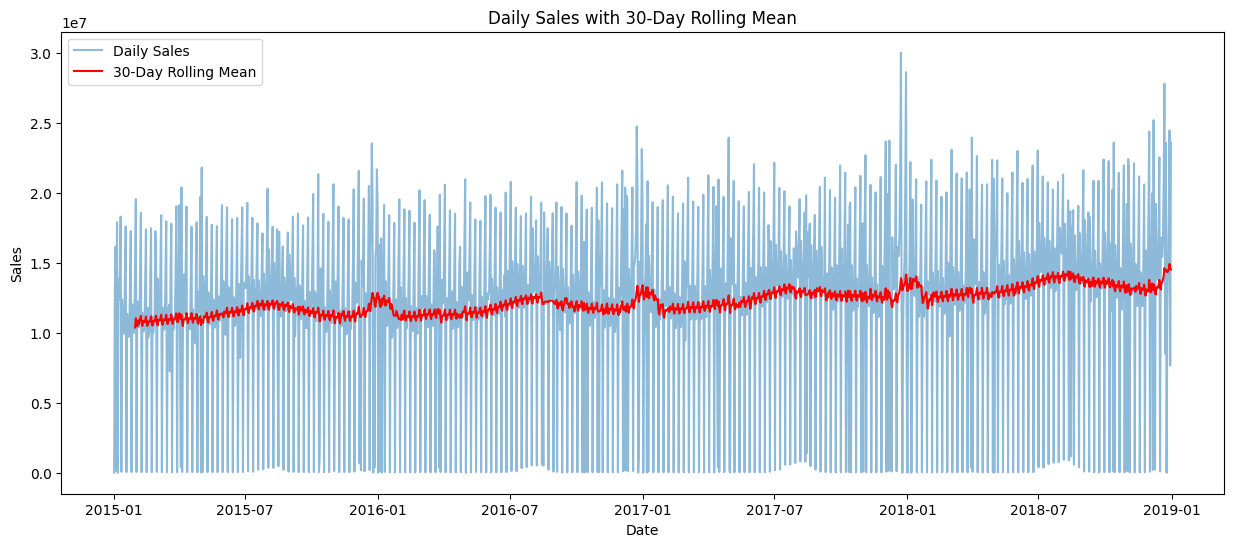

In [113]:
# Lets plot the ts with a rolling mean of 30 days to smooth the data and simplify the analysis
sales_exploration['RollingMean30'] = sales_exploration['SALES'].rolling(window=30).mean()
plt.figure(figsize=(15, 6))
plt.plot(sales_exploration['SALES'], alpha=0.5, label='Daily Sales')
plt.plot(sales_exploration['RollingMean30'], color='red', label='30-Day Rolling Mean')
plt.title('Daily Sales with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

There seems to be a slight positive trend with a seasonal pattern (peaks arround december). 
Lets decompose the time series (trend, seasonal component and residual) and inspect each component.

In [114]:
def plot_decompose_time_series(ts: pd.DataFrame, freq: str, model: str = 'additive'):
    
    if freq not in ['D', 'W', 'M', 'Q', 'Y']:
        raise ValueError(f'Invalid freq value.')

    if model not in ['additive', 'multiplicative']:
        raise ValueError(f'Invalid model value.')
        
    #sales_ts = ts['SALES'].asfreq(freq).fillna(method='ffill')
    sales_ts = ts['SALES'].resample(freq).sum()

    # Decompose the time series
    decomposition = seasonal_decompose(sales_ts, model=model)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the decomposition
    plt.figure(figsize=(20, 12))

    plt.subplot(411)
    plt.plot(ts['SALES'], label='Original', color='blue')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(trend, label='Trend', color='orange')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='red')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

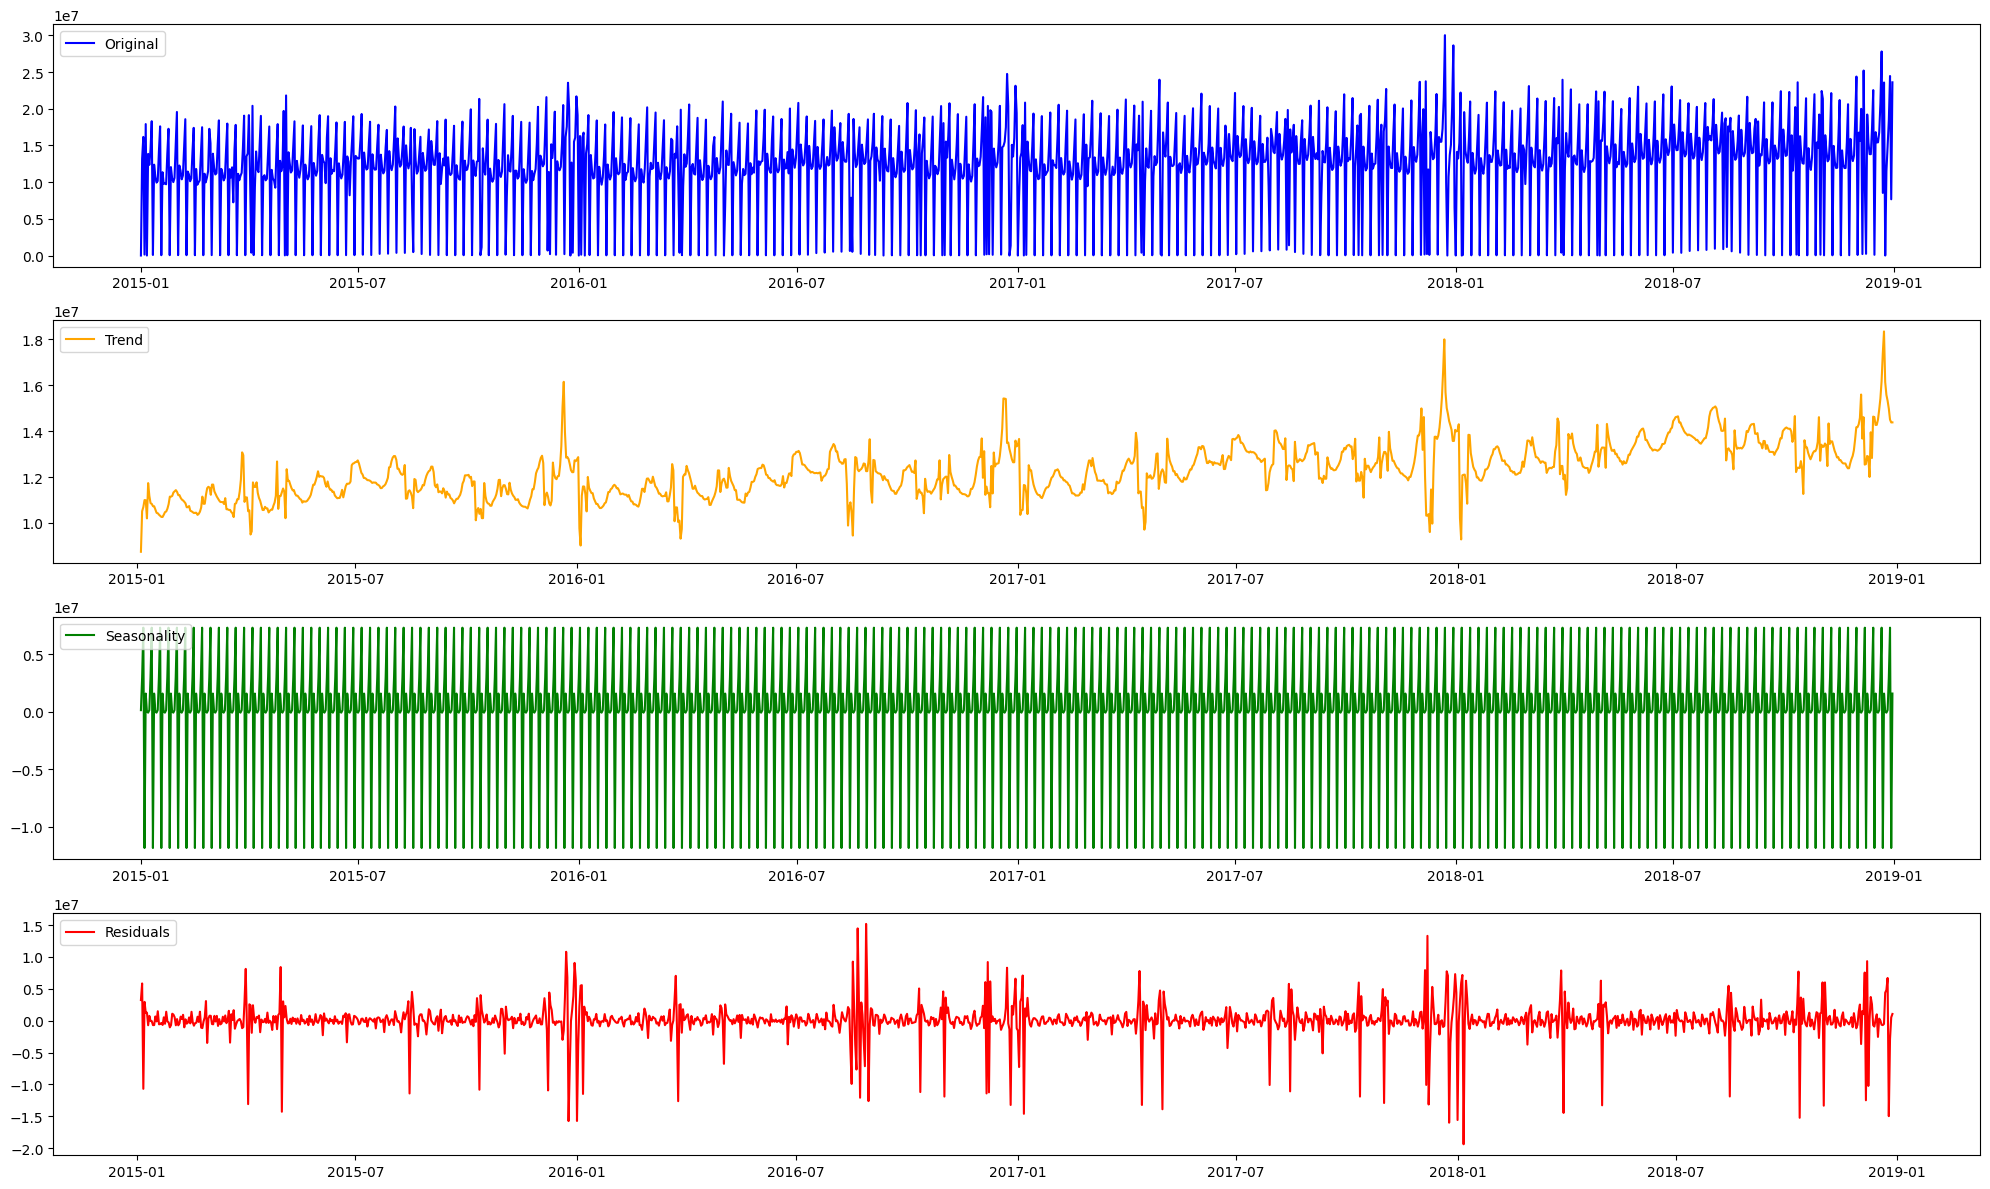

In [115]:
plot_decompose_time_series(sales_exploration, 'D', 'additive')

Based on the plot above and the plots during the first exploration section we can start to see some things, but in order to make it easier to identify trends and seasonal components lets resample the timeseries to take a monthly frequency instead of daily, this will smooth the noise and simplify the analisis.

C:\Users\fer_n\AppData\Local\Temp\ipykernel_24708\2864656597.py:10: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



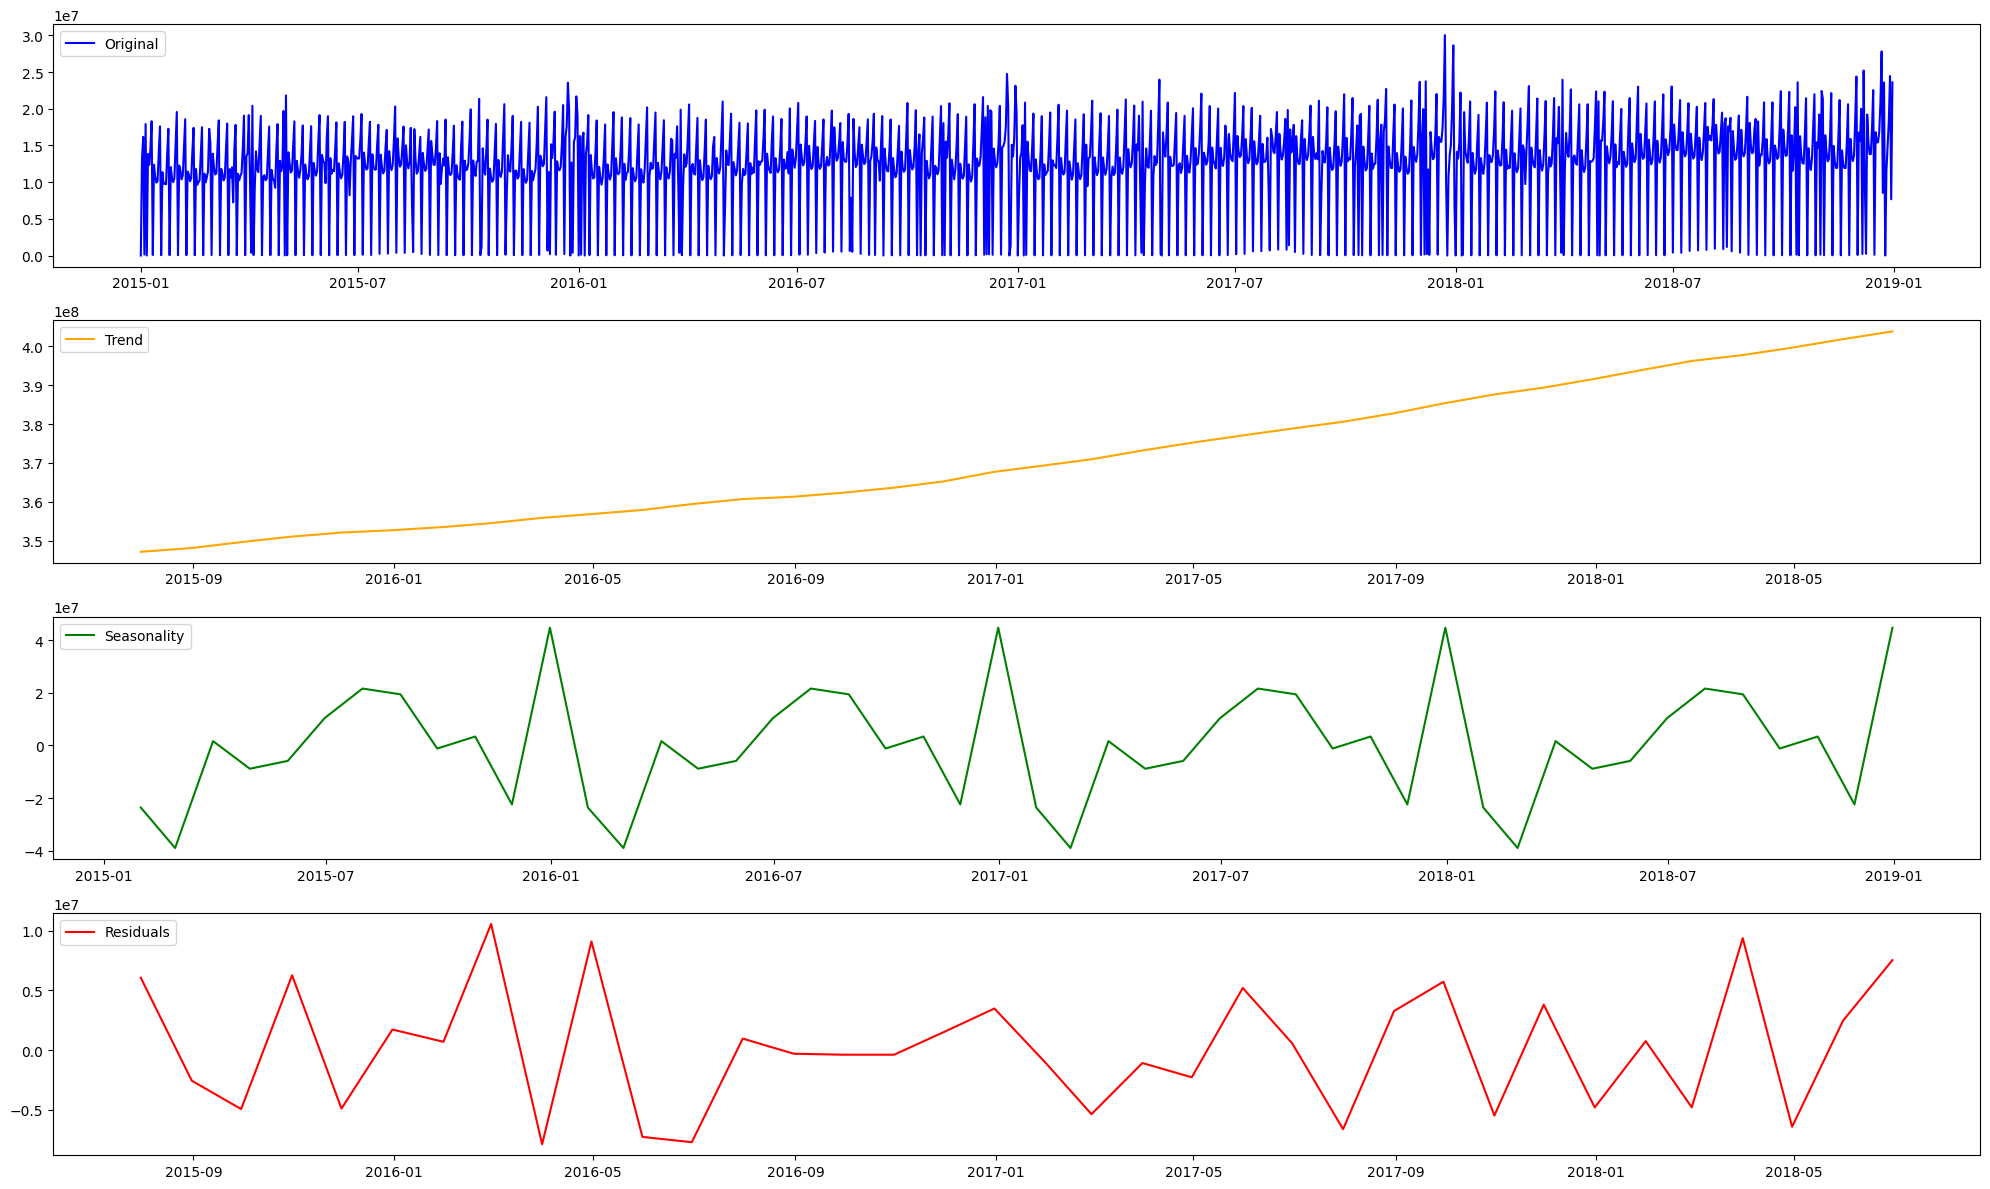

In [116]:
plot_decompose_time_series(sales_exploration, 'M', 'additive')

Based on the previous plots:

**¿Does sales follow a trend?**  
Yes, we can observe a gradual upward trend (increase in sales) over time with occasional spikes, indicating a growing sales pattern. We could also observe this positive trend in the basic sales exploration, where we were comparing the sales on each year.

**¿Can you identify a pattern on sales?**  
Yes, there is a clear seasonal pattern with periodic peaks and valleys (recurring pattern). Specific times of the year experience higher demand (likely related to periodic events such as holidays or end-of-year activities)

**¿Are sales regular over all the year?**  
No, sales are not regular throughout the year; there are higher sales during specific periods, for example in December.

##### Task 7: Optionaly
* If consider there are any kind of analysis that still can be done and would be useful for a forecasting task, that's the place to do it

**Stationarity**

In [117]:
# Depends on the time at which the series is observed? (seasonal effects, trends, and other structures)
# p-value > 0.05: Fail to reject the null hypothesis, non-stationary.
# p-value <= 0.05: Reject the null hypothesis, stationary.
result = adfuller(sales_exploration['SALES'].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# p-value < 0.05: Series is likely non-stationary.
# p-value ≥ 0.05: Fail to reject the null hypothesis; series is stationary.
kpss_stat, p_value, lags, critical_values = kpss(sales_exploration['SALES'].dropna(), nlags='auto')
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)

ADF Statistic: -2.859572425893948
p-value: 0.05025519779812273
KPSS Statistic: 2.229069289633153
p-value: 0.01


C:\Users\fer_n\AppData\Local\Temp\ipykernel_24708\2343251905.py:10: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [118]:
# Differencing since is non stationary
sales_exploration['SALES_diff'] = sales_exploration['SALES'].diff().dropna()

**Autocorrelation and Partial Autocorrelation**

Autocorrelation: Measures the correlation between the time series and its lagged values over successive periods. It helps identify the presence of patterns like seasonality and trend.
Partial Autocorrelation: Measures the correlation between the time series and its lagged values, controlling for the correlations at all shorter lags. It helps in identifying the number of autoregressive terms (p) in an ARIMA model (at this point im not sure which model to use).

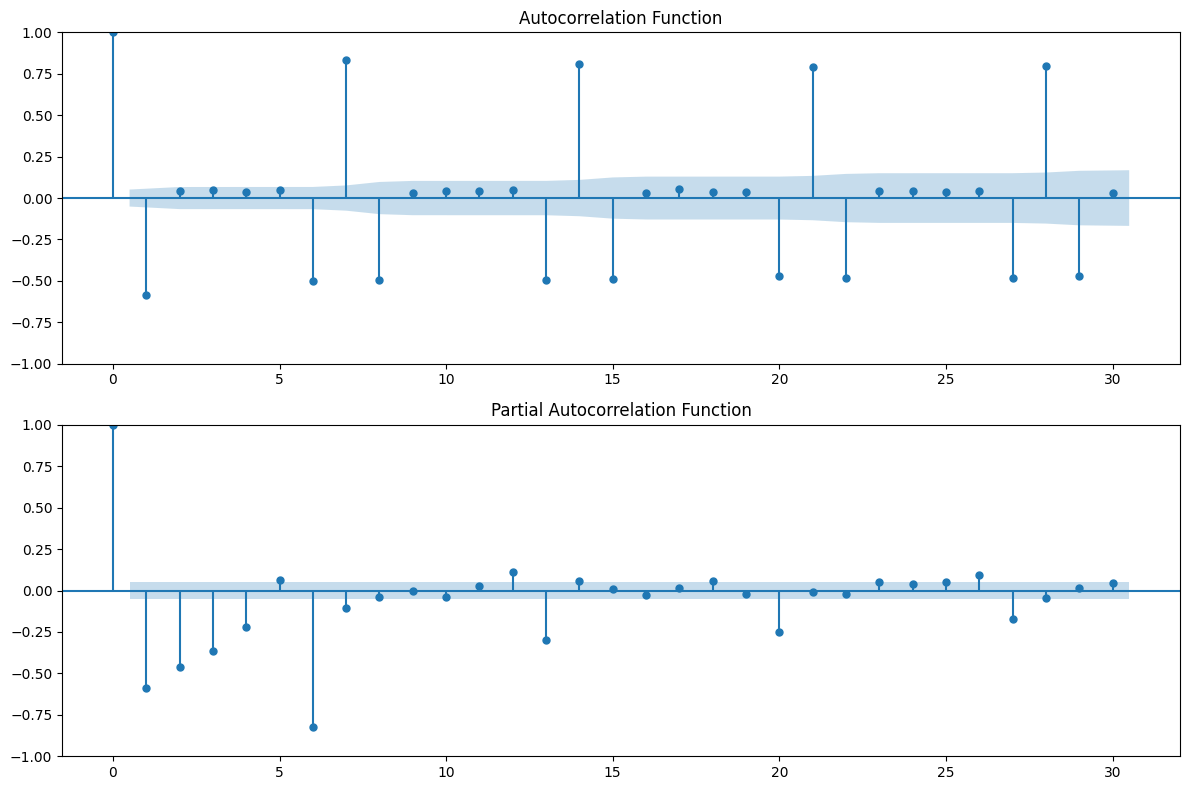

In [119]:
series_to_use = sales_exploration['SALES_diff'].dropna() if 'SALES_diff' in sales_exploration else sales_exploration['SALES']

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot ACF
plot_acf(series_to_use, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function')
# Plot PACF
plot_pacf(series_to_use, lags=30, method='ywm', ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

AR (p): From the PACF plot, the significant lags cut off after lag 1, which suggests AR(1) model might be appropriate.

MA (q): From the ACF plot, significant autocorrelations decay gradually with spikes at lag 2,  MA(1) or MA(2) model could be considered.

Correlation between IPC and Sales

In [120]:
ipc_history_exploration['FEC_VENTA'] = pd.to_datetime(ipc_history_exploration['FEC_VENTA'])

# Assign monthly IPC values to each day of that month
ipc_monthly = ipc_history_exploration.copy()
ipc_monthly['MONTH'] = ipc_history_exploration['FEC_VENTA'].dt.to_period('M')#.dt.to_timestamp()

monthly_sales = sales_exploration.copy()
monthly_sales['MONTH'] = sales_exploration['DATE'].dt.to_period('M')
monthly_sales = monthly_sales.groupby('MONTH')['SALES'].sum().reset_index()

# Merge the data on the 'MONTH' column
if 'DATE' in monthly_sales.columns:
    monthly_sales = monthly_sales.drop('DATE', axis=1)
merged_monthly = pd.merge(monthly_sales, ipc_monthly, on='MONTH', how='left')

# Pearson and Spearman correlation
pearson_corr_monthly = merged_monthly['SALES'].corr(merged_monthly['IPC_VALUE'], method='pearson')
spearman_corr_monthly = merged_monthly['SALES'].corr(merged_monthly['IPC_VALUE'], method='spearman')
print(f'Monthly Data - Pearson Correlation: {pearson_corr_monthly}')
print(f'Monthly Data - Spearman Correlation: {spearman_corr_monthly}')

Monthly Data - Pearson Correlation: 0.24919980757152266
Monthly Data - Spearman Correlation: 0.19920062619218237


We can observe a weak correlation between the current IPC and the sales. Lets try to evaluate the correlation of lagged variables

In [121]:
# Sort the data by month
merged_monthly.sort_values('MONTH', inplace=True)

# Create lagged IPC values (1-month lag)
merged_monthly['IPC_LAG_1'] = merged_monthly['IPC_VALUE'].shift(1)
merged_monthly['IPC_LAG_2'] = merged_monthly['IPC_VALUE'].shift(2)

# Correlation with IPC lagged by 1 month
pearson_corr_lag1 = merged_monthly['SALES'].corr(merged_monthly['IPC_LAG_1'], method='pearson')
spearman_corr_lag1 = merged_monthly['SALES'].corr(merged_monthly['IPC_LAG_1'], method='spearman')
print(f'Monthly Data - Pearson Correlation with IPC Lag 1: {pearson_corr_lag1}')
print(f'Monthly Data - Spearman Correlation with IPC Lag 1: {spearman_corr_lag1}')

# Correlation with IPC lagged by 2 month
pearson_corr_lag2 = merged_monthly['SALES'].corr(merged_monthly['IPC_LAG_2'], method='pearson')
spearman_corr_lag2 = merged_monthly['SALES'].corr(merged_monthly['IPC_LAG_2'], method='spearman')
print(f'Monthly Data - Pearson Correlation with IPC Lag 1: {pearson_corr_lag2}')
print(f'Monthly Data - Spearman Correlation with IPC Lag 1: {spearman_corr_lag2}')

Monthly Data - Pearson Correlation with IPC Lag 1: 0.24117508763254072
Monthly Data - Spearman Correlation with IPC Lag 1: 0.1537398026579153
Monthly Data - Pearson Correlation with IPC Lag 1: 0.2385321160230667
Monthly Data - Spearman Correlation with IPC Lag 1: 0.1801375554117276


Stores over time

In [122]:
# Group by DATE and count unique STORE_IDs
stores = calendar_exploration.groupby('DATE')['STORE_ID'].count()
fig = px.line(stores.reset_index(), x='DATE', y='STORE_ID', title='Number of Stores per Date',
              labels={'STORE_ID': 'Store Count', 'DATE': 'Date'})
# Show the plot
fig.show()

Other possible analysis ideas are:
- **Is worth it to open during holidays in terms of sales?**
- Clustering Analysis
- Residual Diagnostics
- Analyzing Promotional and Marketing Effects (external data source)
- Analyze Customer Behavior Analysis (e.g items bought together, external data source)


##### Task 8: Dataset creation
* At this stage, you should be capable of creating a dataset for a forecasting task. The goal is to populate the SALES column in the test submission file. To achieve this, you will need to first create a dataset and then train a model. You are encouraged to utilize all available information in the CSV files (and optionally, from the internet) to compile a single CSV file containing all chosen features along with the target variable.
* tip: Depending on the model you want to use, it's possible that categorical variables needs a special processing 😉.

Since we have been working in the exploration copies of the datasets we will repeat some code to preprocess and prepare the necessary variables for the resulting dataset.

Prepare Sales

In [123]:
sales_pp = sales_train.copy()

# Ensure DATE is type Datetime and SALES is Float
sales_pp['DATE'] = pd.to_datetime(sales_pp['DATE'])
sales_pp['SALES'] = pd.to_numeric(sales_pp['SALES'], errors='coerce') # There is a line with an 'a' as a SALE instead of a num

# Fill the date gaps
full_date_range = pd.date_range(start=sales_pp['DATE'].min(), end=sales_pp['DATE'].max(), freq='D')
sales_pp.set_index('DATE', inplace=True)
sales_pp = sales_pp.reindex(full_date_range)
sales_pp.index.name = 'DATE'

# Extract year, month, weekday and dayofyear from DATE
sales_pp['DATE'] = pd.to_datetime(sales_pp.index, errors='coerce')
sales_pp['YEAR'] = sales_pp['DATE'].dt.year
sales_pp['MONTH'] = sales_pp['DATE'].dt.month
sales_pp['WEEKDAY'] = sales_pp['DATE'].dt.dayofweek
sales_pp['DAY_OF_YEAR'] = sales_pp['DATE'].dt.dayofyear
sales_pp['DAY_OF_MONTH'] = sales_pp['DATE'].dt.day

In [124]:
# Deal with negative outliers
sales_pp.loc[sales_pp['SALES'] < 0, 'SALES'] = pd.NA

In [125]:
# Deal with missing data of holidays and other dates with all stores closed setting the sales as 0
holidays = [
    '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25',
    '2015-01-06', '2016-01-06', '2018-01-06'
]
closed_days = ['2016-09-11']
zero_sales_days = holidays + closed_days
sales_pp.loc[zero_sales_days, 'SALES'] = 0

In [126]:
# Missing period in august 2016
# Gather all the historical data of August (not 2016)
august_2015_data = sales_pp[
    (sales_pp['MONTH'] == 8) &
    (sales_pp['YEAR'] == 2015)
]
# Calculate annual average growth rate to adjust the trend
annual_sales = sales_pp[sales_pp['YEAR'] != 2016].groupby(sales_pp['YEAR'])['SALES'].sum()
annual_growth_rates = annual_sales.pct_change().dropna()
average_annual_growth_rate = annual_growth_rates.mean()
august_2015_data['ADJUSTED_SALES'] = august_2015_data['SALES'] * (1 + average_annual_growth_rate)

# Impute missing data for August 15-30, 2016
missing_dates = pd.date_range(start='2016-08-15', end='2016-08-30')
august_2015_data.index = august_2015_data.index.day
imputed_sales = august_2015_data.loc[missing_dates.day, 'ADJUSTED_SALES'].values
sales_pp.loc['2016-08-15':'2016-08-30', 'SALES'] = imputed_sales

C:\Users\fer_n\AppData\Local\Temp\ipykernel_24708\4218264814.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
# Deal with 3 random missing dates (near to sundays)
missing_dates = pd.to_datetime(['2017-07-29', '2017-09-11', '2017-12-09'])
for missing_date in missing_dates:
    # 1. Extract day and month from the missing date
    md_day = missing_date.day
    md_month = missing_date.month
    # 2. Calculate the average SALES value from the same day and month of other years
    same_day_month_data = sales_pp[
        (sales_pp['DAY_OF_MONTH'] == md_day) &
        (sales_pp['MONTH'] == md_month) &
        (sales_pp.index != missing_date) # Exclude the missing date itself
    ]
    # 3. Assign this average value to the DataFrame at the missing date
    avg_sales = same_day_month_data['SALES'].mean()
    sales_pp.loc[missing_date, 'SALES'] = avg_sales

In [128]:
# Identify missing dates
missing_dates = sales_pp[sales_pp['SALES'].isnull()].index
print(f'Number of missing days: {len(missing_dates)}')
print(f'Missing dates: {missing_dates}')

Number of missing days: 0
Missing dates: DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq='D')


In [129]:
if 'DATE' in sales_pp.columns:
    sales_pp = sales_pp.drop('DATE', axis=1)
sales_pp = sales_pp.reset_index()

In [130]:
# Add more columns to sales
for lag in range(1, 8):  # Create lags for the past 7 days
    sales_pp[f'SALES_LAG_{lag}'] = sales_pp['SALES'].shift(lag)
sales_pp[f'SALES_LAG_364'] = sales_pp['SALES'].shift(364)

# Rolling Means for different windows
sales_pp['sales_roll_mean_7'] = sales_pp['SALES'].rolling(window=7).mean()
sales_pp['sales_roll_mean_30'] = sales_pp['SALES'].rolling(window=30).mean()

# sales_df['sales_std_7'] = sales_df['sales'].rolling(window=7).std()

sales_pp['is_weekend'] = sales_pp['WEEKDAY'].isin([5, 6]).astype(int)
sales_pp['is_saturday'] = sales_pp['WEEKDAY'].isin([5]).astype(int)
sales_pp['is_sunday'] = sales_pp['WEEKDAY'].isin([6]).astype(int)
sales_pp['is_december'] = (sales_pp['MONTH'] == 12).astype(int)
sales_pp['quarter'] = sales_pp['DATE'].dt.quarter

print(sales_pp.shape)

(1461, 22)


Prepare IPC

In [131]:
# In this case we can just join the df
ipc_pp = ipc_history.copy()
# Add more columns
ipc_pp['FEC_VENTA'] = pd.to_datetime(ipc_pp['FEC_VENTA'])
ipc_pp['IPC_LAG_1'] = ipc_pp['IPC_VALUE'].shift(1)
ipc_pp['IPC_LAG_2'] = ipc_pp['IPC_VALUE'].shift(2)
ipc_pp['IPC_YEAR_CHANGE'] = ipc_pp['IPC_VALUE'].pct_change(12)

print(ipc_pp.shape)

(60, 5)


Prepare Calendar

In [132]:
calendar_pp = calendar.copy()
calendar_pp['DATE'] = pd.to_datetime(calendar_pp['DATE'])

# Function to convert time in HHMM format to minutes
def time_to_minutes(time_value):
    if pd.isnull(time_value):
        return np.nan
    else:
        hours = int(time_value) // 100
        minutes = int(time_value) % 100
        total_minutes = hours * 60 + minutes
        return total_minutes

# Apply the function to OPENING_TIME and CLOSING_TIME
calendar_pp['OPENING_TIME_MIN'] = calendar_pp['OPENING_TIME'].apply(time_to_minutes)
calendar_pp['CLOSING_TIME_MIN'] = calendar_pp['CLOSING_TIME'].apply(time_to_minutes)

# Compute DURATION_MIN
calendar_pp['DURATION_MIN'] = calendar_pp['CLOSING_TIME_MIN'] - calendar_pp['OPENING_TIME_MIN']

# Create dummy variables for STATE
state_dummies = pd.get_dummies(calendar_pp['STATE'], prefix='STATE')
calendar_pp = pd.concat([calendar_pp, state_dummies], axis=1)

In [133]:
# Group by DATE and aggregate
calendar_pp = calendar_pp.groupby('DATE').agg(
    total_stores=('STORE_ID', 'count'),
    num_STATE_A=('STATE_A', 'sum'),
    num_STATE_C=('STATE_C', 'sum'),
    num_STATE_FA=('STATE_FA', 'sum'),
    num_STATE_FM=('STATE_FM', 'sum'),
    num_STATE_CR=('STATE_CR', 'sum'),
    num_HOLIDAY_AND_CLOSED=('HOLIDAY_AND_CLOSED', 'sum'),
    num_UNDER_REFORM=('UNDER_REFORM', 'sum'),
    mean_OPENING_TIME_MIN=('OPENING_TIME_MIN', 'mean'),
    std_OPENING_TIME_MIN=('OPENING_TIME_MIN', 'std'),
    min_OPENING_TIME_MIN=('OPENING_TIME_MIN', 'min'),
    max_OPENING_TIME_MIN=('OPENING_TIME_MIN', 'max'),
    mean_CLOSING_TIME_MIN=('CLOSING_TIME_MIN', 'mean'),
    std_CLOSING_TIME_MIN=('CLOSING_TIME_MIN', 'std'),
    min_CLOSING_TIME_MIN=('CLOSING_TIME_MIN', 'min'),
    max_CLOSING_TIME_MIN=('CLOSING_TIME_MIN', 'max'),
    mean_DURATION_MIN=('DURATION_MIN', 'mean'),
    std_DURATION_MIN=('DURATION_MIN', 'std'),
    min_DURATION_MIN=('DURATION_MIN', 'min'),
    max_DURATION_MIN=('DURATION_MIN', 'max'),
).reset_index()

# Compute percentages
calendar_pp['perc_STATE_A'] = calendar_pp['num_STATE_A'] / calendar_pp['total_stores']
calendar_pp['perc_STATE_C'] = calendar_pp['num_STATE_C'] / calendar_pp['total_stores']
calendar_pp['perc_STATE_FA'] = calendar_pp['num_STATE_FA'] / calendar_pp['total_stores']
calendar_pp['perc_STATE_FM'] = calendar_pp['num_STATE_FM'] / calendar_pp['total_stores']
calendar_pp['perc_STATE_CR'] = calendar_pp['num_STATE_CR'] / calendar_pp['total_stores']
calendar_pp['perc_HOLIDAY_AND_CLOSED'] = calendar_pp['num_HOLIDAY_AND_CLOSED'] / calendar_pp['total_stores']
calendar_pp['perc_UNDER_REFORM'] = calendar_pp['num_UNDER_REFORM'] / calendar_pp['total_stores']

# Compute totals
calendar_pp['stores_closed'] = calendar_pp['num_STATE_C']+calendar_pp['num_STATE_CR']
calendar_pp['stores_open'] = calendar_pp['num_STATE_A']+calendar_pp['num_STATE_FA']+calendar_pp['num_STATE_FM']

# Create flags
# Flag for holiday: if more than 75% of stores have HOLIDAY_AND_CLOSED == 1
calendar_pp['is_holiday'] = (calendar_pp['perc_HOLIDAY_AND_CLOSED'] > 0.70).astype(int)

# Flag for all stores closed
calendar_pp['all_stores_closed'] = (calendar_pp['stores_closed'] == calendar_pp['total_stores']).astype(int)

# Flag for all stores open
calendar_pp['all_stores_open'] = (calendar_pp['stores_open'] == calendar_pp['total_stores']).astype(int)
print(calendar_pp.shape)

(1826, 33)


Join data sources train

In [134]:
# Merge the DataFrames based on their respective date columns
train_dataset_pp = pd.merge(sales_pp, calendar_pp, on='DATE', how='inner')

# Create a variable period month since IPC is monthly
train_dataset_pp['YEAR_MONTH_MERGE'] = train_dataset_pp['DATE'].dt.to_period('M')
ipc_pp['YEAR_MONTH_MERGE'] = ipc_pp['FEC_VENTA'].dt.to_period('M')
train_dataset_pp = pd.merge(train_dataset_pp, ipc_pp, on='YEAR_MONTH_MERGE', how='left')
train_dataset_pp = train_dataset_pp.drop(columns=['FEC_VENTA', 'YEAR_MONTH_MERGE'])
print(train_dataset_pp.columns)
print(train_dataset_pp.shape)
train_dataset_pp


Index(['DATE', 'SALES', 'YEAR', 'MONTH', 'WEEKDAY', 'DAY_OF_YEAR',
       'DAY_OF_MONTH', 'SALES_LAG_1', 'SALES_LAG_2', 'SALES_LAG_3',
       'SALES_LAG_4', 'SALES_LAG_5', 'SALES_LAG_6', 'SALES_LAG_7',
       'SALES_LAG_364', 'sales_roll_mean_7', 'sales_roll_mean_30',
       'is_weekend', 'is_saturday', 'is_sunday', 'is_december', 'quarter',
       'total_stores', 'num_STATE_A', 'num_STATE_C', 'num_STATE_FA',
       'num_STATE_FM', 'num_STATE_CR', 'num_HOLIDAY_AND_CLOSED',
       'num_UNDER_REFORM', 'mean_OPENING_TIME_MIN', 'std_OPENING_TIME_MIN',
       'min_OPENING_TIME_MIN', 'max_OPENING_TIME_MIN', 'mean_CLOSING_TIME_MIN',
       'std_CLOSING_TIME_MIN', 'min_CLOSING_TIME_MIN', 'max_CLOSING_TIME_MIN',
       'mean_DURATION_MIN', 'std_DURATION_MIN', 'min_DURATION_MIN',
       'max_DURATION_MIN', 'perc_STATE_A', 'perc_STATE_C', 'perc_STATE_FA',
       'perc_STATE_FM', 'perc_STATE_CR', 'perc_HOLIDAY_AND_CLOSED',
       'perc_UNDER_REFORM', 'stores_closed', 'stores_open', 'is_holiday',
 

,DATE,SALES,YEAR,MONTH,WEEKDAY,DAY_OF_YEAR,DAY_OF_MONTH,SALES_LAG_1,SALES_LAG_2,SALES_LAG_3,...,perc_UNDER_REFORM,stores_closed,stores_open,is_holiday,all_stores_closed,all_stores_open,IPC_VALUE,IPC_LAG_1,IPC_LAG_2,IPC_YEAR_CHANGE
0,2015-01-01,1.103868e+03,2015,1,3,1,1,NaN,NaN,NaN,...,0.0,1521,0,1,1,0,-0.4,NaN,NaN,NaN
1,2015-01-02,1.317074e+07,2015,1,4,2,2,1.103868e+03,NaN,NaN,...,0.0,13,1508,0,0,0,-0.4,NaN,NaN,NaN
2,2015-01-03,1.616656e+07,2015,1,5,3,3,1.317074e+07,1.103868e+03,NaN,...,0.0,0,1521,0,0,1,-0.4,NaN,NaN,NaN
3,2015-01-04,1.267257e+05,2015,1,6,4,4,1.616656e+07,1.317074e+07,1.103868e+03,...,0.0,1511,10,1,0,0,-0.4,NaN,NaN,NaN
4,2015-01-05,1.791498e+07,2015,1,0,5,5,1.267257e+05,1.616656e+07,1.317074e+07,...,0.0,1,1520,0,0,0,-0.4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,1.501315e+07,2018,12,3,361,27,1.150917e+07,0.000000e+00,2.358273e+07,...,0.0,0,1638,0,0,1,1.3,1.4,1.7,-0.235294
1457,2018-12-28,1.839662e+07,2018,12,4,362,28,1.501315e+07,1.150917e+07,0.000000e+00,...,0.0,2,1636,0,0,0,1.3,1.4,1.7,-0.235294
1458,2018-12-29,2.446802e+07,2018,12,5,363,29,1.839662e+07,1.501315e+07,1.150917e+07,...,0.0,0,1638,0,0,1,1.3,1.4,1.7,-0.235294
1459,2018-12-30,7.664277e+06,2018,12,6,364,30,2.446802e+07,1.839662e+07,1.501315e+07,...,0.0,76,1562,0,0,0,1.3,1.4,1.7,-0.235294


In [135]:
train_dataset_pp.to_csv('../data/dataset_pp.csv', index=False)

Prepare the submission dataset to contain the same features (IPC and calendar feats)

In [136]:
test_pp = sales_test.copy()
test_pp['DATE'] = pd.to_datetime(test_pp['DATE'])

# Fill the date gaps
full_date_range = pd.date_range(start=test_pp['DATE'].min(), end=test_pp['DATE'].max(), freq='D')
test_pp.set_index('DATE', inplace=True)
test_pp = test_pp.reindex(full_date_range)
test_pp.index.name = 'DATE'
test_pp = test_pp.reset_index()

test_pp['YEAR'] = test_pp['DATE'].dt.year
test_pp['MONTH'] = test_pp['DATE'].dt.month
test_pp['WEEKDAY'] = test_pp['DATE'].dt.dayofweek
test_pp['DAY_OF_YEAR'] = test_pp['DATE'].dt.dayofyear
test_pp['DAY_OF_MONTH'] = test_pp['DATE'].dt.day

# Add more columns to sales (will be NANs)
for lag in [1,2,3,4,5,6,7,364]:  # Create lags for the past 7 days
    test_pp[f'SALES_LAG_{lag}'] = test_pp['SALES'].shift(lag)

# Rolling Means for different windows
test_pp['sales_roll_mean_7'] = test_pp['SALES'].rolling(window=7).mean()
test_pp['sales_roll_mean_30'] = test_pp['SALES'].rolling(window=30).mean()

# test_pp['sales_std_7'] = test_pp['sales'].rolling(window=7).std()

test_pp['is_weekend'] = test_pp['WEEKDAY'].isin([5, 6]).astype(int)
test_pp['is_saturday'] = test_pp['WEEKDAY'].isin([5]).astype(int)
test_pp['is_sunday'] = test_pp['WEEKDAY'].isin([6]).astype(int)
test_pp['is_december'] = (test_pp['MONTH'] == 12).astype(int)
test_pp['quarter'] = test_pp['DATE'].dt.quarter

print(test_pp.shape)

(365, 22)


In [137]:
# Merge the DataFrames based on their respective date columns
submission_dataset_pp = pd.merge(test_pp, calendar_pp, on='DATE', how='inner')

# Create a variable period month since IPC is monthly
submission_dataset_pp['YEAR_MONTH_MERGE'] = submission_dataset_pp['DATE'].dt.to_period('M')
ipc_pp['YEAR_MONTH_MERGE'] = ipc_pp['FEC_VENTA'].dt.to_period('M')
submission_dataset_pp = pd.merge(submission_dataset_pp, ipc_pp, on='YEAR_MONTH_MERGE', how='left')
submission_dataset_pp = submission_dataset_pp.drop(columns=['FEC_VENTA', 'YEAR_MONTH_MERGE'])
print(submission_dataset_pp.columns)
print(submission_dataset_pp.shape)
submission_dataset_pp

Index(['DATE', 'SALES', 'YEAR', 'MONTH', 'WEEKDAY', 'DAY_OF_YEAR',
       'DAY_OF_MONTH', 'SALES_LAG_1', 'SALES_LAG_2', 'SALES_LAG_3',
       'SALES_LAG_4', 'SALES_LAG_5', 'SALES_LAG_6', 'SALES_LAG_7',
       'SALES_LAG_364', 'sales_roll_mean_7', 'sales_roll_mean_30',
       'is_weekend', 'is_saturday', 'is_sunday', 'is_december', 'quarter',
       'total_stores', 'num_STATE_A', 'num_STATE_C', 'num_STATE_FA',
       'num_STATE_FM', 'num_STATE_CR', 'num_HOLIDAY_AND_CLOSED',
       'num_UNDER_REFORM', 'mean_OPENING_TIME_MIN', 'std_OPENING_TIME_MIN',
       'min_OPENING_TIME_MIN', 'max_OPENING_TIME_MIN', 'mean_CLOSING_TIME_MIN',
       'std_CLOSING_TIME_MIN', 'min_CLOSING_TIME_MIN', 'max_CLOSING_TIME_MIN',
       'mean_DURATION_MIN', 'std_DURATION_MIN', 'min_DURATION_MIN',
       'max_DURATION_MIN', 'perc_STATE_A', 'perc_STATE_C', 'perc_STATE_FA',
       'perc_STATE_FM', 'perc_STATE_CR', 'perc_HOLIDAY_AND_CLOSED',
       'perc_UNDER_REFORM', 'stores_closed', 'stores_open', 'is_holiday',
 

,DATE,SALES,YEAR,MONTH,WEEKDAY,DAY_OF_YEAR,DAY_OF_MONTH,SALES_LAG_1,SALES_LAG_2,SALES_LAG_3,...,perc_UNDER_REFORM,stores_closed,stores_open,is_holiday,all_stores_closed,all_stores_open,IPC_VALUE,IPC_LAG_1,IPC_LAG_2,IPC_YEAR_CHANGE
0,2019-01-01,NaN,2019,1,1,1,1,NaN,NaN,NaN,...,0.0,1638,0,1,1,0,0.9,1.3,1.4,-0.307692
1,2019-01-02,NaN,2019,1,2,2,2,NaN,NaN,NaN,...,0.0,13,1625,0,0,0,0.9,1.3,1.4,-0.307692
2,2019-01-03,NaN,2019,1,3,3,3,NaN,NaN,NaN,...,0.0,0,1638,0,0,1,0.9,1.3,1.4,-0.307692
3,2019-01-04,NaN,2019,1,4,4,4,NaN,NaN,NaN,...,0.0,0,1638,0,0,1,0.9,1.3,1.4,-0.307692
4,2019-01-05,NaN,2019,1,5,5,5,NaN,NaN,NaN,...,0.0,0,1638,0,0,1,0.9,1.3,1.4,-0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,NaN,2019,12,4,361,27,NaN,NaN,NaN,...,0.0,0,1629,0,0,1,1.7,1.7,1.2,0.307692
361,2019-12-28,NaN,2019,12,5,362,28,NaN,NaN,NaN,...,0.0,0,1629,0,0,1,1.7,1.7,1.2,0.307692
362,2019-12-29,NaN,2019,12,6,363,29,NaN,NaN,NaN,...,0.0,1616,13,1,0,0,1.7,1.7,1.2,0.307692
363,2019-12-30,NaN,2019,12,0,364,30,NaN,NaN,NaN,...,0.0,0,1629,0,0,1,1.7,1.7,1.2,0.307692


In [138]:
submission_dataset_pp.to_csv('../data/submission_dataset_pp.csv', index=False)

Possible data sources:
- pricing mercadona products https://www.kaggle.com/datasets/thegurusteam/mercadona-es-product-pricing/data